In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

# Load the data into Pandas dataframe

In [2]:
df = pd.read_csv(r'spam.csv',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'No. of ham and spam messages')

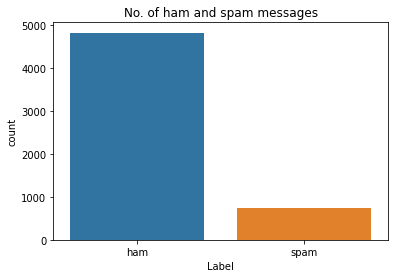

In [5]:
sns.countplot(x ='v1', data = df)
plt.xlabel('Label')
plt.title('No. of ham and spam messages')

# 1) Create input and output vectors.

In [6]:
X = df.v2
Y = df.v1

# 2) Process the labels.

In [7]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

# Split into training and test data.

In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

# Process the data

In [9]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

# Create Model and add Layers

In [10]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('tanh')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy','mse','mae'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

# Fit the model

In [14]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)

Epoch 1/10
28/28 [==============================] - 10s 374ms/step - loss: 0.0491 - accuracy: 0.9905 - mse: 0.0153 - mae: 0.0848 - val_loss: 0.1702 - val_accuracy: 0.9776 - val_mse: 0.0317 - val_mae: 0.1192
Epoch 2/10
28/28 [==============================] - 11s 378ms/step - loss: 0.0493 - accuracy: 0.9919 - mse: 0.0237 - mae: 0.1233 - val_loss: 0.1585 - val_accuracy: 0.9765 - val_mse: 0.0305 - val_mae: 0.1166
Epoch 3/10
28/28 [==============================] - 11s 377ms/step - loss: 0.0406 - accuracy: 0.9944 - mse: 0.0272 - mae: 0.1368 - val_loss: 0.1807 - val_accuracy: 0.9765 - val_mse: 0.0507 - val_mae: 0.1732
Epoch 4/10
28/28 [==============================] - 10s 368ms/step - loss: 0.0586 - accuracy: 0.9944 - mse: 0.0565 - mae: 0.2023 - val_loss: 0.1818 - val_accuracy: 0.9798 - val_mse: 0.1055 - val_mae: 0.2808
Epoch 5/10
28/28 [==============================] - 11s 383ms/step - loss: 0.0407 - accuracy: 0.9961 - mse: 0.0866 - mae: 0.2635 - val_loss: 0.1829 - val_accuracy: 0.9765 -

In [15]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [16]:
accr = model.evaluate(test_sequences_matrix,Y_test)

35/35 [==============================] - 2s 61ms/step - loss: 0.0886 - accuracy: 0.9883 - mse: 0.1577 - mae: 0.3604


In [17]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.089
  Accuracy: 0.988


# Save the Model

In [18]:
model.save('model_spam.h5')

# 

In [ ]:
from tensorflow.keras.models import load_model
m2 = load_model('model_spam.h5')